In [1]:
import re
import ast 
import pickle

import numpy as np
import pandas as pd
import streamlit as st

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# Load the datasets

In [3]:
movies = pd.read_csv('C:/Users/hp/Desktop/netflix/tmdb_5000_movies.csv')
credits = pd.read_csv('C:/Users/hp/Desktop/netflix/tmdb_5000_credits.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/hp/Desktop/netflix/tmdb_5000_credits.csv'

In [ ]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
movies.shape

(4803, 20)

In [ ]:
credits.shape

(4803, 4)

In [ ]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [ ]:
movies['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: title, Length: 4803, dtype: object

In [ ]:
credits['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: title, Length: 4803, dtype: object

# Merge the dataframes

In [ ]:
movies = movies.merge(credits, on='title')
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
movies.shape

(4809, 23)

In [ ]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64

# Choose the relevant features for movie recommendation

- movie_id
- title
- overview
- genres
- keywords
- cast
- crew

In [ ]:
df = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
df.head(3)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [ ]:
df.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [ ]:
df.shape

(4809, 7)

In [ ]:
df.fillna(' ', inplace=True)

In [ ]:
df.isnull().sum()

movie_id    0
title       0
overview    0
genres      0
keywords    0
cast        0
crew        0
dtype: int64

# Final Goal - movie_id + title + tags

In [ ]:
df[:3]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Genres

In [ ]:
df['genres']

0       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1       [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3       [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
                              ...                        
4804    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4805    [{"id": 35, "name": "Comedy"}, {"id": 10749, "...
4806    [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...
4807                                                   []
4808                  [{"id": 99, "name": "Documentary"}]
Name: genres, Length: 4809, dtype: object

In [ ]:
df['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
type(df['genres'][0])

str

In [ ]:
for i in df['genres'][0]:
    print(i)

[
{
"
i
d
"
:
 
2
8
,
 
"
n
a
m
e
"
:
 
"
A
c
t
i
o
n
"
}
,
 
{
"
i
d
"
:
 
1
2
,
 
"
n
a
m
e
"
:
 
"
A
d
v
e
n
t
u
r
e
"
}
,
 
{
"
i
d
"
:
 
1
4
,
 
"
n
a
m
e
"
:
 
"
F
a
n
t
a
s
y
"
}
,
 
{
"
i
d
"
:
 
8
7
8
,
 
"
n
a
m
e
"
:
 
"
S
c
i
e
n
c
e
 
F
i
c
t
i
o
n
"
}
]


In [ ]:
ast.literal_eval(df['genres'][0])

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [ ]:
type(ast.literal_eval(df['genres'][0]))

list

In [ ]:
for i in ast.literal_eval(df['genres'][0]):
    print(i)

{'id': 28, 'name': 'Action'}
{'id': 12, 'name': 'Adventure'}
{'id': 14, 'name': 'Fantasy'}
{'id': 878, 'name': 'Science Fiction'}


In [ ]:
for i in ast.literal_eval(df['genres'][0]):
    print(i['name'])

Action
Adventure
Fantasy
Science Fiction


In [ ]:
def fetch_genres(data):
    
    genres = []
    
    for i in ast.literal_eval(data):
        genres.append(i['name'])
        
    return genres
        
fetch_genres(df['genres'][0])

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [ ]:
# fetch_genres(df['genres'])

In [ ]:
df['genres'].apply(fetch_genres)

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4804                        [Action, Crime, Thriller]
4805                                [Comedy, Romance]
4806               [Comedy, Drama, Romance, TV Movie]
4807                                               []
4808                                    [Documentary]
Name: genres, Length: 4809, dtype: object

In [ ]:
df[:2]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
df['genres'] = df['genres'].apply(fetch_genres)

In [ ]:
df[:3]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Keywords

In [ ]:
df['keywords']

0       [{"id": 1463, "name": "culture clash"}, {"id":...
1       [{"id": 270, "name": "ocean"}, {"id": 726, "na...
2       [{"id": 470, "name": "spy"}, {"id": 818, "name...
3       [{"id": 849, "name": "dc comics"}, {"id": 853,...
4       [{"id": 818, "name": "based on novel"}, {"id":...
                              ...                        
4804    [{"id": 5616, "name": "united states\u2013mexi...
4805                                                   []
4806    [{"id": 248, "name": "date"}, {"id": 699, "nam...
4807                                                   []
4808    [{"id": 1523, "name": "obsession"}, {"id": 224...
Name: keywords, Length: 4809, dtype: object

In [ ]:
df['keywords'][0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [ ]:
ast.literal_eval(df['keywords'][0])

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [ ]:
def fetch_keywords(data):
    
    keywords = []
    
    for i in ast.literal_eval(data):
        keywords.append(i['name'])
        
    return keywords
        
fetch_keywords(df['keywords'][0])

['culture clash',
 'future',
 'space war',
 'space colony',
 'society',
 'space travel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alien planet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'love affair',
 'anti war',
 'power relations',
 'mind and soul',
 '3d']

In [ ]:
df['keywords'].apply(fetch_keywords)

0       [culture clash, future, space war, space colon...
1       [ocean, drug abuse, exotic island, east india ...
2       [spy, based on novel, secret agent, sequel, mi...
3       [dc comics, crime fighter, terrorist, secret i...
4       [based on novel, mars, medallion, space travel...
                              ...                        
4804    [united states–mexico barrier, legs, arms, pap...
4805                                                   []
4806    [date, love at first sight, narration, investi...
4807                                                   []
4808            [obsession, camcorder, crush, dream girl]
Name: keywords, Length: 4809, dtype: object

In [ ]:
df['keywords'] = df['keywords'].apply(fetch_keywords)

In [ ]:
df[:3]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Cast

In [ ]:
df['cast']

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4804    [{"cast_id": 1, "character": "El Mariachi", "c...
4805    [{"cast_id": 1, "character": "Buzzy", "credit_...
4806    [{"cast_id": 8, "character": "Oliver O\u2019To...
4807    [{"cast_id": 3, "character": "Sam", "credit_id...
4808    [{"cast_id": 3, "character": "Herself", "credi...
Name: cast, Length: 4809, dtype: object

In [ ]:
df['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [ ]:
ast.literal_eval(df['cast'][0])

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2},
 {'cast_id': 4,
  'character': 'Col. Quaritch',
  'credit_id': '52fe48009251416c750ac9cf',
  'gender': 2,
  'id': 32747,
  'name': 'Stephen Lang',
  'order': 3},
 {'cast_id': 5,
  'character': 'Trudy Chacon',
  'credit_id': '52fe48009251416c750ac9d3',
  'gender': 1,
  'id': 17647,
  'name': 'Michelle Rodriguez',
  'order': 4},
 {'cast_id': 8,
  'character': 'Selfridge',
  'credit_id': '52fe48009251416c750ac9e1',
  'gender': 2,
  'id': 1771,
  'name': 'Giovanni Ribisi',
  'order': 5},
 {'cast_id': 7,
  'c

In [ ]:
def fetch_cast(data):
    
    cast = []
    counter = 0
    
    for i in ast.literal_eval(data):
        if counter < 3:
            cast.append(i['name'])
        else:
            break
        counter += 1
        
    return cast
        
fetch_cast(df['cast'][0])

['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver']

In [ ]:
df['cast'].apply(fetch_cast)

0        [Sam Worthington, Zoe Saldana, Sigourney Weaver]
1           [Johnny Depp, Orlando Bloom, Keira Knightley]
2            [Daniel Craig, Christoph Waltz, Léa Seydoux]
3            [Christian Bale, Michael Caine, Gary Oldman]
4          [Taylor Kitsch, Lynn Collins, Samantha Morton]
                              ...                        
4804    [Carlos Gallardo, Jaime de Hoyos, Peter Marqua...
4805         [Edward Burns, Kerry Bishé, Marsha Dietlein]
4806           [Eric Mabius, Kristin Booth, Crystal Lowe]
4807            [Daniel Henney, Eliza Coupe, Bill Paxton]
4808    [Drew Barrymore, Brian Herzlinger, Corey Feldman]
Name: cast, Length: 4809, dtype: object

In [ ]:
df['cast'] = df['cast'].apply(fetch_cast)

In [ ]:
df[:3]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


# Crew

In [ ]:
df['crew']

0       [{"credit_id": "52fe48009251416c750aca23", "de...
1       [{"credit_id": "52fe4232c3a36847f800b579", "de...
2       [{"credit_id": "54805967c3a36829b5002c41", "de...
3       [{"credit_id": "52fe4781c3a36847f81398c3", "de...
4       [{"credit_id": "52fe479ac3a36847f813eaa3", "de...
                              ...                        
4804    [{"credit_id": "52fe44eec3a36847f80b280b", "de...
4805    [{"credit_id": "52fe487dc3a368484e0fb013", "de...
4806    [{"credit_id": "52fe4df3c3a36847f8275ecf", "de...
4807    [{"credit_id": "52fe4ad9c3a368484e16a36b", "de...
4808    [{"credit_id": "58ce021b9251415a390165d9", "de...
Name: crew, Length: 4809, dtype: object

In [ ]:
df['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [ ]:
def fetch_director(data):
    
    director = []
    
    for i in ast.literal_eval(data):
        if i['job'] == 'Director':
            director.append(i['name'])
        
    return director
        
fetch_director(df['crew'][0])

['James Cameron']

In [ ]:
df['crew'].apply(fetch_director)

0                                [James Cameron]
1                               [Gore Verbinski]
2                                   [Sam Mendes]
3                            [Christopher Nolan]
4                               [Andrew Stanton]
                          ...                   
4804                          [Robert Rodriguez]
4805                              [Edward Burns]
4806                               [Scott Smith]
4807                               [Daniel Hsia]
4808    [Brian Herzlinger, Jon Gunn, Brett Winn]
Name: crew, Length: 4809, dtype: object

In [ ]:
df['crew'] = df['crew'].apply(fetch_director)

In [ ]:
df.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


# Overview

In [ ]:
df['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4804    El Mariachi just wants to play his guitar and ...
4805    A newlywed couple's honeymoon is upended by th...
4806    "Signed, Sealed, Delivered" introduces a dedic...
4807    When ambitious New York attorney Sam is sent t...
4808    Ever since the second grade when he first saw ...
Name: overview, Length: 4809, dtype: object

In [ ]:
df['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [ ]:
'i am a boy'

'i am a boy'

In [ ]:
'i am a boy'.split()

['i', 'am', 'a', 'boy']

In [ ]:
df['overview'][0].split()

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.']

In [ ]:
df['overview'].apply(lambda x: x.split())

0       [In, the, 22nd, century,, a, paraplegic, Marin...
1       [Captain, Barbossa,, long, believed, to, be, d...
2       [A, cryptic, message, from, Bond’s, past, send...
3       [Following, the, death, of, District, Attorney...
4       [John, Carter, is, a, war-weary,, former, mili...
                              ...                        
4804    [El, Mariachi, just, wants, to, play, his, gui...
4805    [A, newlywed, couple's, honeymoon, is, upended...
4806    ["Signed,, Sealed,, Delivered", introduces, a,...
4807    [When, ambitious, New, York, attorney, Sam, is...
4808    [Ever, since, the, second, grade, when, he, fi...
Name: overview, Length: 4809, dtype: object

In [ ]:
df['overview'] = df['overview'].apply(lambda x: x.split())

In [ ]:
df[:4]

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]


In [ ]:
['a', 'b'] + [1, 2] + ['c', 'd']

['a', 'b', 1, 2, 'c', 'd']

In [ ]:
df['overview'] + df['genres'] + df['keywords'] + df['cast'] + df['crew']

0       [In, the, 22nd, century,, a, paraplegic, Marin...
1       [Captain, Barbossa,, long, believed, to, be, d...
2       [A, cryptic, message, from, Bond’s, past, send...
3       [Following, the, death, of, District, Attorney...
4       [John, Carter, is, a, war-weary,, former, mili...
                              ...                        
4804    [El, Mariachi, just, wants, to, play, his, gui...
4805    [A, newlywed, couple's, honeymoon, is, upended...
4806    ["Signed,, Sealed,, Delivered", introduces, a,...
4807    [When, ambitious, New, York, attorney, Sam, is...
4808    [Ever, since, the, second, grade, when, he, fi...
Length: 4809, dtype: object

In [ ]:
(df['overview'] + df['genres'] + df['keywords'] + df['cast'] + df['crew'])[0]

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.',
 'Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'culture clash',
 'future',
 'space war',
 'space colony',
 'society',
 'space travel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alien planet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'love affair',
 'anti war',
 'power relations',
 'mind and soul',
 '3d',
 'Sam Worthington',
 'Zoe Saldana',
 'Sigourney Weaver',
 'James Cameron']

In [ ]:
df['tags'] = df['overview'] + df['genres'] + df['keywords'] + df['cast'] + df['crew']

In [ ]:
df[:3]

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[A, cryptic, message, from, Bond’s, past, send..."


In [ ]:
data = df[['movie_id', 'title', 'tags']]
data

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."
...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is..."


In [ ]:
data['tags']

0       [In, the, 22nd, century,, a, paraplegic, Marin...
1       [Captain, Barbossa,, long, believed, to, be, d...
2       [A, cryptic, message, from, Bond’s, past, send...
3       [Following, the, death, of, District, Attorney...
4       [John, Carter, is, a, war-weary,, former, mili...
                              ...                        
4804    [El, Mariachi, just, wants, to, play, his, gui...
4805    [A, newlywed, couple's, honeymoon, is, upended...
4806    ["Signed,, Sealed,, Delivered", introduces, a,...
4807    [When, ambitious, New, York, attorney, Sam, is...
4808    [Ever, since, the, second, grade, when, he, fi...
Name: tags, Length: 4809, dtype: object

In [ ]:
print(data['tags'][68])

['After', 'being', 'held', 'captive', 'in', 'an', 'Afghan', 'cave,', 'billionaire', 'engineer', 'Tony', 'Stark', 'creates', 'a', 'unique', 'weaponized', 'suit', 'of', 'armor', 'to', 'fight', 'evil.', 'Action', 'Science Fiction', 'Adventure', 'middle east', 'arms dealer', 'malibu', 'marvel comic', 'superhero', 'based on comic book', 'tony stark', 'iron man', 'aftercreditsstinger', 'marvel cinematic universe', 'counter terrorism', 'agent coulson', 'Robert Downey Jr.', 'Terrence Howard', 'Jeff Bridges', 'Jon Favreau']


In [ ]:
'i am a boy'

'i am a boy'

In [ ]:
'i am a boy'.replace(' ', '')

'iamaboy'

In [ ]:
data['tags'].apply(lambda x: [i.replace(' ', '') for i in x])

0       [In, the, 22nd, century,, a, paraplegic, Marin...
1       [Captain, Barbossa,, long, believed, to, be, d...
2       [A, cryptic, message, from, Bond’s, past, send...
3       [Following, the, death, of, District, Attorney...
4       [John, Carter, is, a, war-weary,, former, mili...
                              ...                        
4804    [El, Mariachi, just, wants, to, play, his, gui...
4805    [A, newlywed, couple's, honeymoon, is, upended...
4806    ["Signed,, Sealed,, Delivered", introduces, a,...
4807    [When, ambitious, New, York, attorney, Sam, is...
4808    [Ever, since, the, second, grade, when, he, fi...
Name: tags, Length: 4809, dtype: object

In [ ]:
data['tags'].apply(lambda x: [i.replace(' ', '') for i in x])[68]

['After',
 'being',
 'held',
 'captive',
 'in',
 'an',
 'Afghan',
 'cave,',
 'billionaire',
 'engineer',
 'Tony',
 'Stark',
 'creates',
 'a',
 'unique',
 'weaponized',
 'suit',
 'of',
 'armor',
 'to',
 'fight',
 'evil.',
 'Action',
 'ScienceFiction',
 'Adventure',
 'middleeast',
 'armsdealer',
 'malibu',
 'marvelcomic',
 'superhero',
 'basedoncomicbook',
 'tonystark',
 'ironman',
 'aftercreditsstinger',
 'marvelcinematicuniverse',
 'counterterrorism',
 'agentcoulson',
 'RobertDowneyJr.',
 'TerrenceHoward',
 'JeffBridges',
 'JonFavreau']

In [ ]:
data['tags'].apply(lambda x: [i.replace(' ', '') for i in x])[0]

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.',
 'Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'cultureclash',
 'future',
 'spacewar',
 'spacecolony',
 'society',
 'spacetravel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alienplanet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'loveaffair',
 'antiwar',
 'powerrelations',
 'mindandsoul',
 '3d',
 'SamWorthington',
 'ZoeSaldana',
 'SigourneyWeaver',
 'JamesCameron']

In [ ]:
data['tags'] = data['tags'].apply(lambda x: [i.replace(' ', '') for i in x])

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."
...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is..."


In [ ]:
'i am a boy'.split()

['i', 'am', 'a', 'boy']

In [ ]:
" ".join(['i', 'am', 'a', 'boy'])

'i am a boy'

In [ ]:
data['tags'].apply(lambda x: " ".join(x))

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4804    El Mariachi just wants to play his guitar and ...
4805    A newlywed couple's honeymoon is upended by th...
4806    "Signed, Sealed, Delivered" introduces a dedic...
4807    When ambitious New York attorney Sam is sent t...
4808    Ever since the second grade when he first saw ...
Name: tags, Length: 4809, dtype: object

In [ ]:
data['tags'] = data['tags'].apply(lambda x: " ".join(x))

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."
...,...,...,...
4804,9367,El Mariachi,El Mariachi just wants to play his guitar and ...
4805,72766,Newlyweds,A newlywed couple's honeymoon is upended by th...
4806,231617,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic..."
4807,126186,Shanghai Calling,When ambitious New York attorney Sam is sent t...


In [ ]:
data['tags'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [ ]:
"HELLO WORLD"

'HELLO WORLD'

In [ ]:
"HELLO WORLD".lower()

'hello world'

In [ ]:
 data['tags'].apply(lambda x: x.lower())

0       in the 22nd century, a paraplegic marine is di...
1       captain barbossa, long believed to be dead, ha...
2       a cryptic message from bond’s past sends him o...
3       following the death of district attorney harve...
4       john carter is a war-weary, former military ca...
                              ...                        
4804    el mariachi just wants to play his guitar and ...
4805    a newlywed couple's honeymoon is upended by th...
4806    "signed, sealed, delivered" introduces a dedic...
4807    when ambitious new york attorney sam is sent t...
4808    ever since the second grade when he first saw ...
Name: tags, Length: 4809, dtype: object

In [ ]:
data['tags'] = data['tags'].apply(lambda x: x.lower())

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."
...,...,...,...
4804,9367,El Mariachi,el mariachi just wants to play his guitar and ...
4805,72766,Newlyweds,a newlywed couple's honeymoon is upended by th...
4806,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduces a dedic..."
4807,126186,Shanghai Calling,when ambitious new york attorney sam is sent t...


In [ ]:
data['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

# NLP techniques to preprocess text data

- Tokenization
- Lower Case
- Stemming
- Stopwords Removal
- Vector Encoding

In [ ]:
'I am a boy'.lower()

'i am a boy'

In [ ]:
'i am a boy'.split()

['i', 'am', 'a', 'boy']

In [ ]:
['love', 'lover', 'lovers', 'loving', 'lovely']

In [ ]:
['love']

In [ ]:
data['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

In [ ]:
ps = PorterStemmer()

def text_preprocess(text_data):
    
    lst = []
    
    for i in text_data.split():
        lst.append(ps.stem(i))
    
    return " ".join(lst)

In [ ]:
text_preprocess(data['tags'][0])

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d samworthington zoesaldana sigourneyweav jamescameron'

In [ ]:
print(text_preprocess(data['tags'][0]))   # Updated

['in', 'the', '22nd', 'century,', 'a', 'parapleg', 'marin', 'is', 'dispatch', 'to', 'the', 'moon', 'pandora', 'on', 'a', 'uniqu', 'mission,', 'but', 'becom', 'torn', 'between', 'follow', 'order', 'and', 'protect', 'an', 'alien', 'civilization.', 'action', 'adventur', 'fantasi', 'sciencefict', 'cultureclash', 'futur', 'spacewar', 'spacecoloni', 'societi', 'spacetravel', 'futurist', 'romanc', 'space', 'alien', 'tribe', 'alienplanet', 'cgi', 'marin', 'soldier', 'battl', 'loveaffair', 'antiwar', 'powerrel', 'mindandsoul', '3d', 'samworthington', 'zoesaldana', 'sigourneyweav', 'jamescameron']


In [ ]:
print(text_preprocess(data['tags'][0]))   # old

['in', 'the', '22nd', 'century,', 'a', 'paraplegic', 'marine', 'is', 'dispatched', 'to', 'the', 'moon', 'pandora', 'on', 'a', 'unique', 'mission,', 'but', 'becomes', 'torn', 'between', 'following', 'orders', 'and', 'protecting', 'an', 'alien', 'civilization.', 'action', 'adventure', 'fantasy', 'sciencefiction', 'cultureclash', 'future', 'spacewar', 'spacecolony', 'society', 'spacetravel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alienplanet', 'cgi', 'marine', 'soldier', 'battle', 'loveaffair', 'antiwar', 'powerrelations', 'mindandsoul', '3d', 'samworthington', 'zoesaldana', 'sigourneyweaver', 'jamescameron']


In [ ]:
data['tags'].apply(text_preprocess)

0       in the 22nd century, a parapleg marin is dispa...
1       captain barbossa, long believ to be dead, ha c...
2       a cryptic messag from bond’ past send him on a...
3       follow the death of district attorney harvey d...
4       john carter is a war-weary, former militari ca...
                              ...                        
4804    el mariachi just want to play hi guitar and ca...
4805    a newlyw couple' honeymoon is upend by the arr...
4806    "signed, sealed, delivered" introduc a dedic q...
4807    when ambiti new york attorney sam is sent to s...
4808    ever sinc the second grade when he first saw h...
Name: tags, Length: 4809, dtype: object

In [ ]:
data['tags'] = data['tags'].apply(text_preprocess)

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4804,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4805,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4806,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4807,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...


# BOW (Bag of Words) Method to encode text into vectors

In [ ]:
cv = CountVectorizer(max_features=5000, stop_words='english')
cv

CountVectorizer(max_features=5000, stop_words='english')

In [ ]:
cv.fit_transform(data['tags'])

<4809x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 145438 stored elements in Compressed Sparse Row format>

In [ ]:
cv.get_feature_names_out()

array(['000', '007', '10', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

In [ ]:
for i in cv.get_feature_names_out():
    print(i)

000
007
10
100
11
12
13
14
15
16
17
17th
18
18th
18thcenturi
19
1910
1920
1930
1940
1944
1950
1950s
1960
1960s
1970
1970s
1971
1974
1976
1980
1985
1990
1999
19th
19thcenturi
20
200
2003
2009
20th
24
25
30
300
3d
40
50
500
60
70
80
aaron
aaroneckhart
abandon
abduct
abigailbreslin
abil
abl
aboard
abov
abus
academ
academi
accept
access
accid
accident
acclaim
accompani
accomplish
account
accus
ace
achiev
acquaint
act
action
actionhero
activ
activist
activities
actor
actress
actual
ad
adam
adamsandl
adamshankman
adapt
add
addict
adjust
admir
admit
adolesc
adopt
ador
adrienbrodi
adult
adultanim
adulteri
adulthood
advanc
adventur
adventure
adventures
advertis
advic
advis
affair
affect
afghanistan
africa
african
africanamerican
aftercreditssting
afterlif
aftermath
ag
age
agediffer
agenc
agency
agenda
agent
agents
aggress
ago
agre
ahead
aid
aidanquinn
ail
aim
air
airplan
airplanecrash
airport
aka
al
alabama
alan
alaska
albert
alcatraz
alcohol
alecbaldwin
alex
alexkendrick
alfredhitchcock
alfred

In [ ]:
vectors = cv.fit_transform(data['tags']).toarray()
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
vectors.shape

(4809, 5000)

In [ ]:
vectors[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
for i in vectors[0]:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


# Cosine Similarity

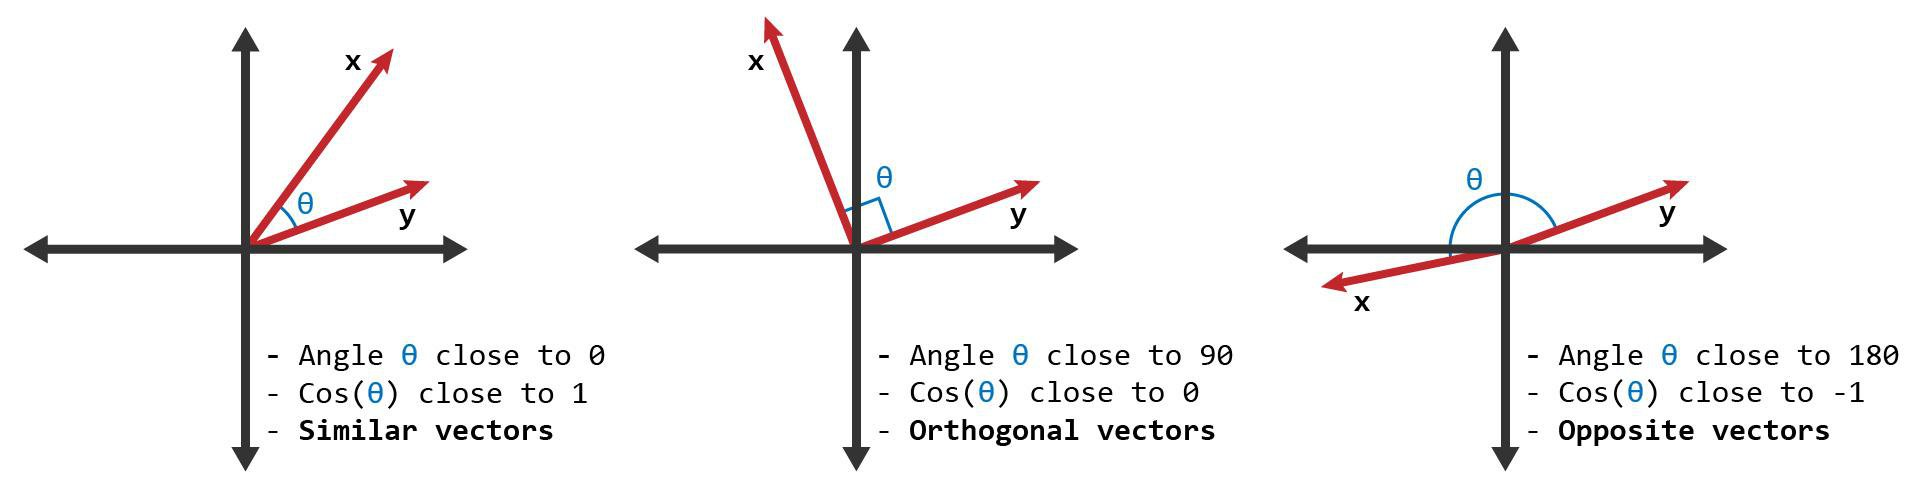

In [ ]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
cosine_similarity(vectors)

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [ ]:
similarity = cosine_similarity(vectors)
similarity

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [ ]:
similarity[0]

array([1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
       0.        ])

In [ ]:
sorted(similarity[0])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
sorted(similarity[0], reverse=True)

[1.0000000000000002,
 0.28676966733820225,
 0.26901379342448517,
 0.2605130246476754,
 0.255608593705383,
 0.25038669783359574,
 0.24511108480187255,
 0.24455799402225925,
 0.23179316248638276,
 0.23174488732966073,
 0.2278389747471728,
 0.2252817784447915,
 0.22269966704152225,
 0.21853668936906193,
 0.21239769762143662,
 0.2108663315950723,
 0.2105263157894737,
 0.20602141085758227,
 0.20443988269091456,
 0.20437977982832192,
 0.20395079136182276,
 0.2029530274475215,
 0.2029530274475215,
 0.20277677641345318,
 0.2024645717996314,
 0.2020475485519274,
 0.1979082783981174,
 0.19767387315371682,
 0.1976738731537168,
 0.19672236884115843,
 0.19134594929397597,
 0.19134594929397597,
 0.19088542889273336,
 0.19088542889273336,
 0.19007487139298027,
 0.18731716231633883,
 0.1873171623163388,
 0.1873171623163388,
 0.18693292157876878,
 0.1860807318911967,
 0.18394180184548975,
 0.1813690625275029,
 0.18074256993863339,
 0.17996850826633903,
 0.17954621161490197,
 0.1777046633277277,
 0.1769

In [ ]:
list(enumerate(similarity[0]))

[(0, 1.0000000000000002),
 (1, 0.08346223261119858),
 (2, 0.08603090020146065),
 (3, 0.0734718358370645),
 (4, 0.19134594929397597),
 (5, 0.10838874619051501),
 (6, 0.04024218182927669),
 (7, 0.14673479641335554),
 (8, 0.05923488777590923),
 (9, 0.0967301666813349),
 (10, 0.10259783520851541),
 (11, 0.09464970485606021),
 (12, 0.09037128496931669),
 (13, 0.04499212706658476),
 (14, 0.12824729401064427),
 (15, 0.06282808624375433),
 (16, 0.07894736842105264),
 (17, 0.13977653617040256),
 (18, 0.09493290614465533),
 (19, 0.0830812984794528),
 (20, 0.058038100008800934),
 (21, 0.10968169942141635),
 (22, 0.0662266178532522),
 (23, 0.08740748201220976),
 (24, 0.0533380747062665),
 (25, 0.05101627678885769),
 (26, 0.15389675281277312),
 (27, 0.18693292157876878),
 (28, 0.116543309349613),
 (29, 0.065033247714309),
 (30, 0.06684847767323797),
 (31, 0.15907119074394446),
 (32, 0.08520286456846099),
 (33, 0.09733285267845754),
 (34, 0.0),
 (35, 0.09933992677987831),
 (36, 0.17119059581558146),

In [ ]:
sorted(list(enumerate(similarity[0])), reverse=True)

[(4808, 0.0),
 (4807, 0.0),
 (4806, 0.04499212706658476),
 (4805, 0.046829290579084706),
 (4804, 0.019252140716412975),
 (4803, 0.0),
 (4802, 0.052631578947368425),
 (4801, 0.04223886030955117),
 (4800, 0.0),
 (4799, 0.0),
 (4798, 0.0),
 (4797, 0.0),
 (4796, 0.05407380704358751),
 (4795, 0.0),
 (4794, 0.0),
 (4793, 0.0582716546748065),
 (4792, 0.060833032924035954),
 (4791, 0.0),
 (4790, 0.019117977822546817),
 (4789, 0.0),
 (4788, 0.019672236884115842),
 (4787, 0.043355498476206004),
 (4786, 0.0),
 (4785, 0.025649458802128853),
 (4784, 0.0582716546748065),
 (4783, 0.0),
 (4782, 0.0),
 (4781, 0.0),
 (4780, 0.10814761408717502),
 (4779, 0.0),
 (4778, 0.05647824947249051),
 (4777, 0.0),
 (4776, 0.029617443887954616),
 (4775, 0.023918243661746996),
 (4774, 0.039344473768231684),
 (4773, 0.0),
 (4772, 0.0),
 (4771, 0.0),
 (4770, 0.03627381250550058),
 (4769, 0.017595383576944672),
 (4768, 0.0),
 (4767, 0.0),
 (4766, 0.0),
 (4765, 0.0),
 (4764, 0.02742042485535409),
 (4763, 0.02533472959690

In [ ]:
sorted(list(enumerate(similarity[0])), reverse=True, key=lambda x: x[1])

[(0, 1.0000000000000002),
 (1216, 0.28676966733820225),
 (2409, 0.26901379342448517),
 (3731, 0.2605130246476754),
 (507, 0.255608593705383),
 (539, 0.25038669783359574),
 (582, 0.24511108480187255),
 (1204, 0.24455799402225925),
 (1194, 0.23179316248638276),
 (778, 0.23174488732966073),
 (4049, 0.2278389747471728),
 (1920, 0.2252817784447915),
 (61, 0.22269966704152225),
 (2787, 0.21853668936906193),
 (172, 0.21239769762143662),
 (972, 0.2108663315950723),
 (322, 0.2105263157894737),
 (2972, 0.20602141085758227),
 (2333, 0.20443988269091456),
 (3609, 0.20437977982832192),
 (260, 0.20395079136182276),
 (151, 0.2029530274475215),
 (4194, 0.2029530274475215),
 (1444, 0.20277677641345318),
 (74, 0.2024645717996314),
 (1089, 0.2020475485519274),
 (3676, 0.1979082783981174),
 (973, 0.19767387315371682),
 (577, 0.1976738731537168),
 (47, 0.19672236884115843),
 (4, 0.19134594929397597),
 (942, 0.19134594929397597),
 (495, 0.19088542889273336),
 (1201, 0.19088542889273336),
 (305, 0.1900748713

In [ ]:
sorted(list(enumerate(similarity[0])), reverse=True, key=lambda x: x[1])[1:6]

[(1216, 0.28676966733820225),
 (2409, 0.26901379342448517),
 (3731, 0.2605130246476754),
 (507, 0.255608593705383),
 (539, 0.25038669783359574)]

In [ ]:
data.iloc[0]

movie_id                                                19995
title                                                  Avatar
tags        in the 22nd century, a parapleg marin is dispa...
Name: 0, dtype: object

In [ ]:
data.iloc[1216]

movie_id                                                  440
title                             Aliens vs Predator: Requiem
tags        a sequel to 2004' alien vs. predator, the icon...
Name: 1216, dtype: object

In [ ]:
data.iloc[2409]

movie_id                                                  679
title                                                  Aliens
tags        when ripley' lifepod is found by a salvag crew...
Name: 2409, dtype: object

In [ ]:
sorted(list(enumerate(similarity[68])), reverse=True, key=lambda x: x[1])[1:6]

[(31, 0.43701422443753773),
 (79, 0.4041894792106529),
 (7, 0.3359355065735125),
 (16, 0.2711138549079501),
 (26, 0.26424909878161656)]

In [ ]:
data.iloc[68]

movie_id                                                 1726
title                                                Iron Man
tags        after be held captiv in an afghan cave, billio...
Name: 68, dtype: object

In [ ]:
data.iloc[31]

movie_id                                                68721
title                                              Iron Man 3
tags        when toni stark' world is torn apart by a form...
Name: 31, dtype: object

In [ ]:
data.iloc[79]

movie_id                                                10138
title                                              Iron Man 2
tags        with the world now awar of hi dual life as the...
Name: 79, dtype: object

# Final Recommendation Function

In [ ]:
def recommend(movie):
    
    movie_index = data[data['title'] == movie].index[0]
    distance = similarity[movie_index]
    movie_list = sorted(list(enumerate(distance)), reverse=True, key=lambda x: x[1])[1:6]
    
    for i in movie_list:
        print(data.iloc[i[0]].title)

In [ ]:
recommend('Iron Man')

Iron Man 3
Iron Man 2
Avengers: Age of Ultron
The Avengers
Captain America: Civil War


In [ ]:
recommend('Superman')

Superman Returns
Superman II
Iron Man 2
Superman III
Superman IV: The Quest for Peace


In [ ]:
recommend('X-Men')

X2
X-Men: The Last Stand
X-Men: Apocalypse
Iron Man 3
X-Men: First Class


In [ ]:
recommend('Spider-Man')

Spider-Man 3
Spider-Man 2
The Amazing Spider-Man 2
Arachnophobia
Kick-Ass


In [ ]:
data[data['title'] == 'Iron Man 2']

,movie_id,title,tags
79,10138,Iron Man 2,with the world now awar of hi dual life as the...


In [ ]:
data[data['title'] == 'Iron Man 2'].index[0]

79

In [ ]:
similarity[79]

array([0.06231097, 0.10979072, 0.04526787, ..., 0.01775552, 0.16461885,
       0.09762721])

In [ ]:
data.iloc[1216]

movie_id                                                  440
title                             Aliens vs Predator: Requiem
tags        a sequel to 2004' alien vs. predator, the icon...
Name: 1216, dtype: object

In [ ]:
data.iloc[1216].title

'Aliens vs Predator: Requiem'

# Pickle Module

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4804,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4805,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4806,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4807,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...


In [ ]:
similarity

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [ ]:
data.to_dict()

{'movie_id': {0: 19995,
  1: 285,
  2: 206647,
  3: 49026,
  4: 49529,
  5: 559,
  6: 38757,
  7: 99861,
  8: 767,
  9: 209112,
  10: 1452,
  11: 10764,
  12: 58,
  13: 57201,
  14: 49521,
  15: 2454,
  16: 24428,
  17: 1865,
  18: 41154,
  19: 122917,
  20: 1930,
  21: 20662,
  22: 57158,
  23: 2268,
  24: 254,
  25: 597,
  26: 271110,
  27: 44833,
  28: 135397,
  29: 37724,
  30: 558,
  31: 68721,
  32: 12155,
  33: 36668,
  34: 62211,
  35: 8373,
  36: 91314,
  37: 68728,
  38: 102382,
  39: 20526,
  40: 49013,
  41: 44912,
  42: 10193,
  43: 534,
  44: 168259,
  45: 72190,
  46: 127585,
  47: 54138,
  48: 81005,
  49: 64682,
  50: 9543,
  51: 68726,
  52: 38356,
  53: 217,
  54: 105864,
  55: 62177,
  56: 188927,
  57: 10681,
  58: 5174,
  59: 14161,
  60: 17979,
  61: 76757,
  62: 258489,
  63: 411,
  64: 246655,
  65: 155,
  66: 14160,
  67: 15512,
  68: 1726,
  69: 44826,
  70: 8487,
  71: 1735,
  72: 297761,
  73: 2698,
  74: 137113,
  75: 9804,
  76: 14869,
  77: 150540,
  78:

In [ ]:
pickle.dump(data.to_dict(), open('movie_dict.pkl', mode='wb'))

In [ ]:
pickle.dump(similarity, open('similarity.pkl', mode='wb'))

In [ ]:
data['title'].values

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       ..., 'Signed, Sealed, Delivered', 'Shanghai Calling',
       'My Date with Drew'], dtype=object)

In [ ]:
list(data['title'].values)

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Quantum of Solace',
 "Pirates of the Caribbean: Dead Man's Chest",
 'The Lone Ranger',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Avengers',
 'Pirates of the Caribbean: On Stranger Tides',
 'Men in Black 3',
 'The Hobbit: The Battle of the Five Armies',
 'The Amazing Spider-Man',
 'Robin Hood',
 'The Hobbit: The Desolation of Smaug',
 'The Golden Compass',
 'King Kong',
 'Titanic',
 'Captain America: Civil War',
 'Battleship',
 'Jurassic World',
 'Skyfall',
 'Spider-Man 2',
 'Iron Man 3',
 'Alice in Wonderland',
 'X-Men: The Last Stand',
 'Monsters University',
 'Transformers: Revenge of the Fallen',
 'Transformers: Age of Extinction',
 'Oz: The Great and Powerful',
 'The Amazing Spider-Man 2',

In [ ]:
data

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4804,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4805,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4806,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4807,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...
